In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from sklearn.metrics import matthews_corrcoef
from matplotlib_venn import venn2

In [4]:
import glob

In [5]:
pd.options.display.max_columns = 999
pd.options.display.max_rows = 100
pd.set_option('display.max_colwidth', 200)
sns.set_context("paper")
sns.set(font_scale=1.5, font='Arial')

In [6]:
SUPPLEMENT_PATH = "./supp_data/"
RAW_FIGURE_PATH = "./raw_figure/"

In [24]:
VARIANTS = "./data/ExACr0.3.sites.vep.vcf.filtered.tsv"
GENES = "./data/genes.txt"
PGX_GENES = "/Users/schaerfe/Documents/Privat/Dropbox/Charlotta_MyDrug_paper_material/Manuscript/Re-SubmissionGMed/Supplementary_Tables2-7.xlsx"
CADD_FILE = "/Users/schaerfe/Documents/Privat/Dropbox/Charlotta_MyDrug_paper_material/Misc/ExAC_r0.3_inclAnno_pgx.tsv"
EVMUTATION_DIR = "/Users/schaerfe/Documents/Privat/Dropbox/drugs/midrug_data/midrug_graphs/effects/"


In [8]:
# POPS = ["AFR", "AMR", "SAS", "EAS", "NFE", "FIN"]
# COLOR_MAPPING = {"Target": "#A6002C", "target": "#A6002C", "Target genes": "#A6002C",
#                  "ADME": "#6C226C", 'other ADME genes': "#6C226C",
#                  "Cytochrome": "#2A3FA6", 'Cytochrome P450s': "#2A3FA6",
#                  "All genes": "grey"}

# Load ExAC variants

In [9]:
variants = pd.read_csv("supp_data/variants_for_paper.txt", sep="\t")
variants.columns = [c.replace('CSQ.', '').replace('INFO.', '') for c in variants.columns]

/Users/schaerfe/Documents/Privat/Dropbox/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (1,81,82,83,84,85,95,97,98,100,101,102,103,104,106,114,115,116,121,122,123,124) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
len(variants)

6864326

In [11]:
len(variants)

6864326

# Load gene info

In [12]:
genes = pd.read_csv(GENES, sep="\t", comment="#")

/Users/schaerfe/Documents/Privat/Dropbox/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (13,19,20,21,22,23,24,26,27,28,29,30,31,32,33,34,35,36,37,38,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Load genes analysed in paper

In [13]:
pgx_genes = pd.read_excel(PGX_GENES, sheetname="Supplemantal Table 2 - CAP")

In [14]:
len(pgx_genes)

806

## Filter variants to those in genes from paper

In [15]:
variants_druggenes = variants.loc[variants.HGNC_ID.isin(pgx_genes["HGNC ID"].tolist())]

In [16]:
len(variants_druggenes)

334397

## Load genes with EVmutation predictions

In [31]:
modeled_proteins = set([f.replace(EVMUTATION_DIR, "").split("_")[0].split("-")[0] for f in glob.glob(EVMUTATION_DIR + "*.csv")])


In [33]:
modeled_genes = genes.loc[genes.uniprot_ids.isin(modeled_proteins)]

In [34]:
len(modeled_genes)

6718

## Intersect with proteins for which EVmutation scores have been computed

In [36]:
len(pgx_genes), len(modeled_genes.loc[modeled_genes.hgnc_id.isin(pgx_genes["HGNC ID"])])

(806, 545)

In [37]:
modeled_pgx_genes = modeled_genes.loc[modeled_genes.hgnc_id.isin(pgx_genes["HGNC ID"])]

## Filter drug-related variants to those in genes with EVmutation prediction

In [38]:
variants_modeled_genes = variants_druggenes.loc[variants_druggenes.HGNC_ID.isin(modeled_genes.hgnc_id.tolist())]

In [39]:
len(variants_modeled_genes)

243007

## Filter variants to SNPs with effect on protein sequence

In [40]:
variants_modeled_genes = variants_modeled_genes.dropna(subset=["Protein_position", "Amino_acids"])

In [41]:
len(variants_modeled_genes)

116580

## Split SIFT and PolyPhen predictions into multiple columns

In [42]:
variants_modeled_genes = variants_modeled_genes.join(
    pd.DataFrame(variants_modeled_genes["SIFT"].str.extract('([a-z]*)\((.*)\)')).rename(columns={0:"SIFT_class", 1:"SIFT_score"}))\
    .join(
    pd.DataFrame(variants_modeled_genes["PolyPhen"].str.extract('([a-z_]*)\((.*)\)')).rename(columns={0:"PolyPhen_class", 1:"PolyPhen_score"}))

/Users/schaerfe/Documents/Privat/Dropbox/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  from ipykernel import kernelapp as app
/Users/schaerfe/Documents/Privat/Dropbox/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)


## Split amino acid effect column into wt and mutation

In [43]:
variants_modeled_genes = variants_modeled_genes.join(
    pd.DataFrame(variants_modeled_genes["Amino_acids"].str.extract('([A-Z]*)/([A-Z]*)')).rename(columns={0:"wt", 1:"mut"}))

/Users/schaerfe/Documents/Privat/Dropbox/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  from ipykernel import kernelapp as app


In [44]:
variants_modeled_genes = variants_modeled_genes.merge(genes[["hgnc_id", "uniprot_ids", "entry_name"]] , left_on="HGNC_ID", right_on="hgnc_id")

# Import EVmutation predictions

In [46]:
predictions = []
for f in glob.glob(EVMUTATION_DIR + "*.csv"):
    protein = f.replace(EVMUTATION_DIR, "").split("_")[0].split("-")[0]
    if protein not in modeled_pgx_genes.uniprot_ids.unique():
        continue
    prediction = pd.read_csv(f, sep=";")
    # exclude wild type scores
    prediction = prediction.loc[prediction.wt != prediction.subs]
    prediction["prediction_epistatic_z"] = st.zscore(prediction["prediction_epistatic"])
    prediction["prediction_independent_z"] = st.zscore(prediction["prediction_independent"])
    prediction["protein"] = protein
    predictions.append(prediction)

## Combine all predictions into one DataFrame

In [47]:
evmutation_predictions = pd.concat(predictions)

## Plot score distribution

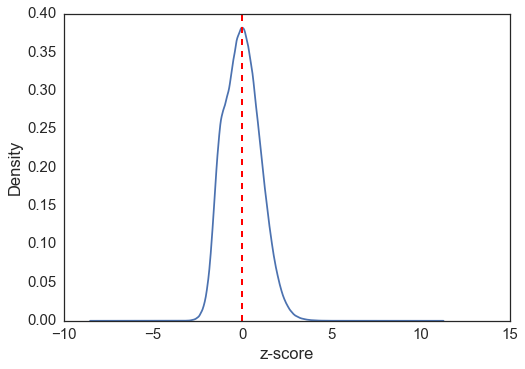

In [48]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 1)
    # evmutation_predictions["prediction_epistatic_z"].plot.density(ax=ax)
    evmutation_predictions["prediction_epistatic_z"].plot.density(ax=ax)
    ax.set_xlabel("z-score")
    ax.axvline(x=0, linewidth=2, color='r', linestyle='--')
    # ax.axvline(x=1, linewidth=2, color='r', linestyle='--')

# Merge evmutation predictions to drug-related variants

## Exclude variants in which more than one protein position is affected

In [49]:
variants_modeled_genes2 = variants_modeled_genes.loc[~variants_modeled_genes["Protein_position"].str.contains("-")]

In [50]:
len(variants_modeled_genes2)

114925

## Convert protein position column to numeric

In [51]:
variants_modeled_genes2["Protein_position"] = pd.to_numeric(variants_modeled_genes2["Protein_position"])

/Users/schaerfe/Documents/Privat/Dropbox/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


## Merge variant data with evmutation scores

In [55]:
variants_predicted = variants_modeled_genes2.merge(evmutation_predictions,
                                                   left_on=["uniprot_ids", "Protein_position", "wt", "mut"],
                                                   right_on=["protein", "pos", "wt", "subs"])

In [56]:
len(variants_predicted)

52328

In [57]:
variants_predicted["SIFT_score"] = pd.to_numeric(variants_predicted["SIFT_score"])
variants_predicted["PolyPhen_score"] = pd.to_numeric(variants_predicted["PolyPhen_score"])

In [58]:
variants_predicted[["PolyPhen_score", "SIFT_score", "prediction_epistatic_z", "prediction_independent_z"]].corr()

,PolyPhen_score,SIFT_score,prediction_epistatic_z,prediction_independent_z
PolyPhen_score,1.000000,-0.541918,-0.661422,-0.502883
SIFT_score,-0.541918,1.000000,0.624969,0.472349
prediction_epistatic_z,-0.661422,0.624969,1.000000,0.767380
prediction_independent_z,-0.502883,0.472349,0.767380,1.000000


# Binary classification based on z-score thresholds

In [59]:
both = variants_predicted.loc[(variants_predicted.PolyPhen.str.contains("damaging", na=False)) &
                              (variants_predicted.SIFT.str.contains("deleterious", na=False))]
poly_lc = variants_predicted.loc[(variants_predicted.PolyPhen.str.contains("possibly_damaging", na=False)) &
                              (~variants_predicted.SIFT.str.contains("deleterious", na=False))]
poly_hc = variants_predicted.loc[(variants_predicted.PolyPhen.str.contains("probably_damaging", na=False)) &
                                 (~variants_predicted.SIFT.str.contains("deleterious", na=False))]
poly = variants_predicted.loc[(variants_predicted.PolyPhen.str.contains("damaging", na=False)) &
                                 (~variants_predicted.SIFT.str.contains("deleterious", na=False))]
sift = variants_predicted.loc[(~variants_predicted.PolyPhen.str.contains("damaging", na=False)) &
                              (variants_predicted.SIFT.str.contains("deleterious", na=False))]
no = variants_predicted.loc[(~variants_predicted.PolyPhen.str.contains("damaging", na=False)) &
                            (~variants_predicted.SIFT.str.contains("deleterious", na=False))]

## Plot score distribution of EVmutation scores of ExAC variants in drug-related genes depending on PolyPhen&SIFT classification

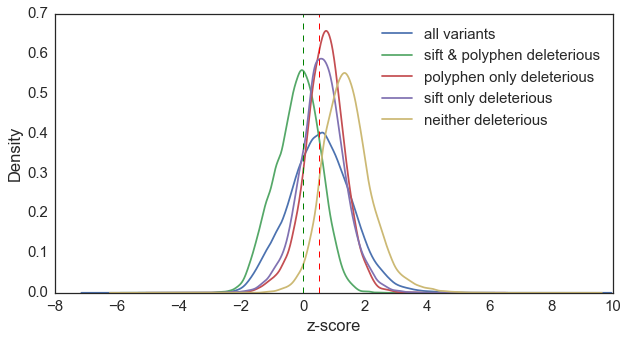

In [60]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    variants_predicted["prediction_epistatic_z"].plot.density(ax=ax, label="all variants")
    both["prediction_epistatic_z"].plot.density(ax=ax, label="sift & polyphen deleterious")
    poly["prediction_epistatic_z"].plot.density(ax=ax, label="polyphen only deleterious")
    sift["prediction_epistatic_z"].plot.density(ax=ax, label="sift only deleterious")
    no["prediction_epistatic_z"].plot.density(ax=ax, label="neither deleterious")
    ax.set_xlabel("z-score")
    ax.axvline(linewidth=1, color='green', linestyle='--')
    ax.axvline(x=0.5, linewidth=1, color='r', linestyle='--')
    ax.legend()

In [61]:
st.skewtest(variants_predicted["prediction_epistatic"])

SkewtestResult(statistic=13.671552492960645, pvalue=1.5015699071041702e-42)

## Overlap between SIFT&PolyPhen deleterious and EVmutation z-score < 0.5

In [62]:
evmutation_delet = variants_predicted.loc[variants_predicted.prediction_epistatic_z <= 0.5]

In [63]:
b = len(set(both.var_uid.tolist()) & set(evmutation_delet.var_uid.tolist()))
p = len(set(both.var_uid.tolist()) - set(evmutation_delet.var_uid.tolist()))
e = len(set(evmutation_delet.var_uid.tolist()) - set(both.var_uid.tolist()))

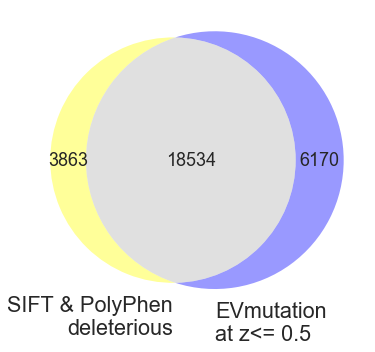

In [67]:
venn2(subsets = (p, e, b), set_labels = ('SIFT & PolyPhen\ndeleterious', 'EVmutation\nat z<= 0.5'),
      set_colors=('yellow', 'blue'))
plt.ylabel("");
plt.savefig(RAW_FIGURE_PATH + "overlap_SIFTPolyPhen_EVmutation.pdf", dpi=300)

# Include CADD scores for variants

## Import CADD scores

In [ ]:
# Filter large CADD score file to only genes of interest
pgx_symbols = pgx_genes["gene symbol"].tolist()
with open(CADD_FILE, "r") as f:
    with open(SUPPLEMENT_PATH + "ExAC_r0.3_inclAnno_pgx.tsv", "w") as of:
        for line in f:
            if line.startswith("##"):
                of.write(line)
                continue

            if line.startswith("#"):
                elements = line.strip().split("\t")
                geneidx = elements.index("GeneName")
                of.write(line.strip() + "\tvar_uid\n")
                continue


            elements = line.strip().split("\t")
            if elements[geneidx] in pgx_symbols:
                varuid = elements[0] + "-" + elements[geneidx] + "-" + elements[1] + "-" +\
                         elements[2] + "-" + elements[4]
                of.write(line.strip() + "\t" + varuid + "\n")


In [68]:
cadd = pd.read_csv(SUPPLEMENT_PATH + "ExAC_r0.3_inclAnno_pgx.tsv", sep="\t", skiprows=1)

/Users/schaerfe/Documents/Privat/Dropbox/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0,8,75,76) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [69]:
len(cadd)

584320

## Join variants in drug-related genes with CADD scores

In [70]:
variants_druggenes_cadd = variants_druggenes.merge(cadd, left_on=["CHROM", "POS", "REF", "ALT"],
                                                   right_on=["#Chrom", "Pos", "Ref", "Alt"])

In [71]:
variants_druggenes_cadd = variants_druggenes_cadd.drop_duplicates()

In [72]:
len(variants_druggenes_cadd), len(variants_druggenes)

The history saving thread hit an unexpected error (OperationalError('unable to open database file',)).History will not be written to the database.

(410383, 334397)

## Compare overlap SIFT&PolyPhen with CADD variant sets (>20)

In [73]:
both_2 = variants_druggenes_cadd.loc[(variants_druggenes_cadd.SIFT.str.contains("deleterious")) &
                                     (variants_druggenes_cadd.PolyPhen.str.contains("damaging"))]

In [74]:
cadd_15 = variants_druggenes_cadd.loc[variants_druggenes_cadd.PHRED > 15.0]
cadd_20 = variants_druggenes_cadd.loc[variants_druggenes_cadd.PHRED > 20.0]
cadd_25 = variants_druggenes_cadd.loc[variants_druggenes_cadd.PHRED > 25.0]

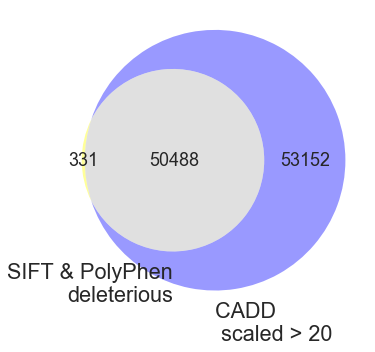

In [79]:
b = len(set(both_2.var_uid_x.tolist()) & set(cadd_20.var_uid_x.tolist()))
p = len(set(both_2.var_uid_x.tolist()) - set(cadd_20.var_uid_x.tolist()))
e = len(set(cadd_20.var_uid_x.tolist()) - set(both_2.var_uid_x.tolist()))
venn2(subsets = (p, e, b), set_labels = ('SIFT & PolyPhen\ndeleterious', 'CADD \n scaled > 20'),
      set_colors=('yellow', 'blue'))
plt.ylabel("");
plt.savefig(RAW_FIGURE_PATH + "overlap_SIFTPolyPhen_CADD20.pdf", dpi=300)

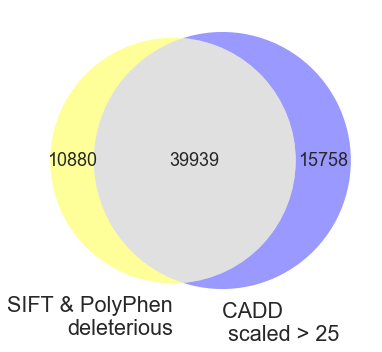

In [78]:
b = len(set(both_2.var_uid_x.tolist()) & set(cadd_25.var_uid_x.tolist()))
p = len(set(both_2.var_uid_x.tolist()) - set(cadd_25.var_uid_x.tolist()))
e = len(set(cadd_25.var_uid_x.tolist()) - set(both_2.var_uid_x.tolist()))
venn2(subsets = (p, e, b), set_labels = ('SIFT & PolyPhen\ndeleterious', 'CADD \n scaled > 25'),
      set_colors=('yellow', 'blue'))
plt.ylabel("");
plt.savefig(RAW_FIGURE_PATH + "overlap_SIFTPolyPhen_CADD25.pdf", dpi=300)

## Compare overlap SIFT&PolyPhen, EVmutation (z < 0.5) with CADD variant sets (>20)

In [368]:
import sys
sys.path.insert(0, '../scripts/')
# import pop_stats_tools as tools
import pop_stats_plotting_tools as pt

In [396]:
shared_variants = reduce(set.intersection, map(set, [variants_druggenes.var_uid.tolist(),
                                                     variants_modeled_genes2.var_uid.tolist(),
                                                     variants_druggenes_cadd.var_uid_x.tolist()]))


In [397]:
len(shared_variants)

114226

In [400]:
len(reduce(set.intersection, map(set, [both_2.loc[both_2.var_uid_x.isin(shared_variants)].var_uid_x.tolist(),
                                       evmutation_delet.loc[evmutation_delet.var_uid.isin(shared_variants)].var_uid.tolist(),
                                       cadd_20.loc[cadd_20.var_uid_x.isin(shared_variants)].var_uid_x.tolist()])))

18385

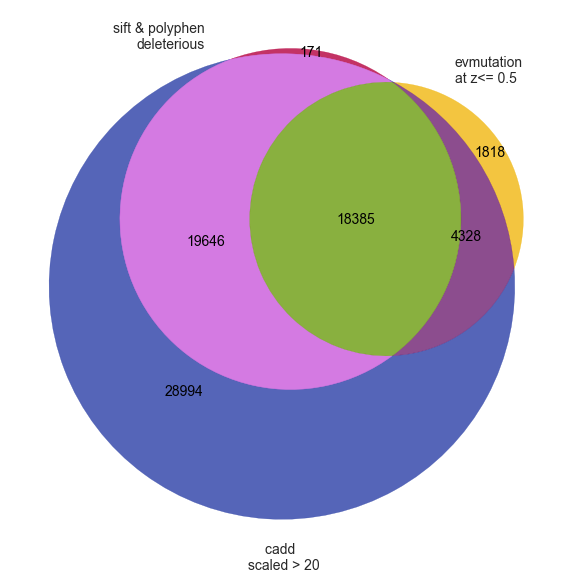

In [401]:
pt.three_circle_venn(set(both_2.loc[both_2.var_uid_x.isin(shared_variants)].var_uid_x.tolist()),
                     set(evmutation_delet.loc[evmutation_delet.var_uid.isin(shared_variants)].var_uid.tolist()),
                     set(cadd_20.loc[cadd_20.var_uid_x.isin(shared_variants)].var_uid_x.tolist()),
                     labels=('sift & polyphen\ndeleterious', 'evmutation\nat z<= 0.5', 'cadd \n scaled > 20'),
                     figsize=(10, 10), fontcolor='black')

# Compare ExAC frequencies to other sources 

In [402]:
tpmt_variants = pd.read_excel("/Users/schaerfe/Documents/Privat/Dropbox/Charlotta_MyDrug_paper_material/Misc/TMPT_frequencies_Rellingetal2011.xlsx")

In [403]:
tpmt_variants

,Allele,SNP,Caucasian,Mediteranean,South American,African,Middle Eastern,Mexican,Asian,South West Asian
0,*1,rs1800462|G>G;rs1800460|C>C; rs1142345|T>T,0.95671,0.96081,0.95233,0.94284,0.96987,0.925,0.98364,0.97837
1,*2,rs1800462|G>C,0.0019,0.00408,0.00876,0.000873,0.00749,0.00592,0,0.0025
2,*3A,rs1800460|C>T;rs1142345|T>C,0.0354,0.0254,0.0287,0.00218,0.0114,0.0533,0.000119,0.00583
3,*3B,rs1800460|C>T,0.000461,0.00426,0.000486,0,0.00562,0.0069,0,0
4,*3C,rs1142345|T>C,0.004207,0.00545,0.00924,0.048,0.00562,0.00888,0.0157,0.0133
5,*4,rs1800584|C>T,na,na,0.000486,na,na,na,na,na
6,*6,NaN,na,na,na,na,na,na,0.000537,na
7,*7,NaN,5.76e-05,na,na,na,na,na,na,na
8,*8,NaN,na,na,na,0.00611,na,na,na,na
9,*9,NaN,0.00115,na,na,na,na,na,na,na


In [418]:
tpmt_variants.ix[2:3].sum()

Allele                                                *3A*3B
SNP                 rs1800460|C>T;rs1142345|T>Crs1800460|C>T
Caucasian                                           0.035861
Mediteranean                                         0.02966
South American                                      0.029186
African                                              0.00218
Middle Eastern                                       0.01702
Mexican                                               0.0602
Asian                                               0.000119
South West Asian                                     0.00583
dtype: object

In [417]:
tpmt_variants.ix[[2,4]].sum()

Allele                                                *3A*3C
SNP                 rs1800460|C>T;rs1142345|T>Crs1142345|T>C
Caucasian                                           0.039607
Mediteranean                                         0.03085
South American                                       0.03794
African                                              0.05018
Middle Eastern                                       0.01702
Mexican                                              0.06218
Asian                                               0.015819
South West Asian                                     0.01913
dtype: object

In [405]:
variants.loc[variants.ID.str.contains("rs1800462", na=False)]

,Transcript,CHROM,POS,REF,ALT,ID,QUAL,FILTER,var_type,var_subtype,AC,AC_AFR,AC_AMR,AC_Adj,AC_EAS,AC_FIN,AC_Hemi,AC_Het,AC_Hom,AC_NFE,AC_OTH,AC_SAS,AF,AN,AN_AFR,AN_AMR,AN_Adj,AN_EAS,AN_FIN,AN_NFE,AN_OTH,AN_SAS,BaseQRankSum,CCC,ClippingRankSum,DB,DP,DS,END,FS,GQ_MEAN,GQ_STDDEV,HWP,HaplotypeScore,Hemi_AFR,Hemi_AMR,Hemi_EAS,Hemi_FIN,Hemi_NFE,Hemi_OTH,Hemi_SAS,Het_AFR,Het_AMR,Het_EAS,Het_FIN,Het_NFE,Het_OTH,Het_SAS,Hom_AFR,Hom_AMR,Hom_EAS,Hom_FIN,Hom_NFE,Hom_OTH,Hom_SAS,InbreedingCoeff,MLEAC,MLEAF,MQ,MQ0,MQRankSum,NCC,QD,ReadPosRankSum,VQSLOD,culprit,Allele,Gene,Feature,Feature_type,Consequence,cDNA_position,CDS_position,Protein_position,Amino_acids,Codons,Existing_variation,ALLELE_NUM,DISTANCE,STRAND,SYMBOL,SYMBOL_SOURCE,HGNC_ID,BIOTYPE,CANONICAL,CCDS,ENSP,SWISSPROT,TREMBL,UNIPARC,SIFT,PolyPhen,EXON,INTRON,DOMAINS,HGVSc,HGVSp,GMAF,AFR_MAF,AMR_MAF,ASN_MAF,EUR_MAF,AA_MAF,EA_MAF,CLIN_SIG,SOMATIC,PUBMED,MOTIF_NAME,MOTIF_POS,HIGH_INF_POS,MOTIF_SCORE_CHANGE,LoF_info,LoF_flags,LoF_filter,LoF,COMP.AF_AFR,COMP.AF_AMR,COMP.AF_EAS,COMP.AF_FIN,COMP.AF_NFE,COMP.AF_OTH,COMP.AF_SAS,COMP.AF_Adj,var_uid
2329450,transcript_00001,6,18143955,C,G,rs1800462,226006.83,PASS,snp,tv,166,5,28,166,0,1,NaN,166,0,130,2,0,0.001367,121408,10088,11458,120178,8584,6576,66144,900,16428,-0.75,NaN,-0.025,True,2035644,NaN,NaN,1.98,72.03,59.34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,28,0,1,130,2,0,0,0,0,0,0,0,0,0.0031,NaN,NaN,59.86,0,0.348,16,12.05,0.503,3.83,MQ,G,ENSG00000137364,ENST00000309983,Transcript,missense_variant,324,238,80,A/P,Gca/Cca,rs1800462&CM951239,1,NaN,-1,TPMT,HGNC,12014,protein_coding,YES,CCDS4543.1,ENSP00000312304,TPMT_HUMAN,NaN,UPI0000137261,deleterious(0.01),probably_damaging(0.99),4/9,NaN,Pfam_domain:PF05724&Superfamily_domains:SSF53335&PIRSF_domain:PIRSF023956,ENST00000309983.4:c.238G>C,ENSP00000312304.4:p.Ala80Pro,G:0.0037,G:0.0041,G:0.01,NaN,G:0.0040,G:0,G:0.002326,NaN,NaN,18547414&23133420&18685564&22385887,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000496,0.002444,0.0,0.000152,0.001965,0.002222,0.0,0.001381,6-TPMT-18143955-C-G


In [406]:
variants.loc[variants.ID.str.contains("rs1800460", na=False)]

,Transcript,CHROM,POS,REF,ALT,ID,QUAL,FILTER,var_type,var_subtype,AC,AC_AFR,AC_AMR,AC_Adj,AC_EAS,AC_FIN,AC_Hemi,AC_Het,AC_Hom,AC_NFE,AC_OTH,AC_SAS,AF,AN,AN_AFR,AN_AMR,AN_Adj,AN_EAS,AN_FIN,AN_NFE,AN_OTH,AN_SAS,BaseQRankSum,CCC,ClippingRankSum,DB,DP,DS,END,FS,GQ_MEAN,GQ_STDDEV,HWP,HaplotypeScore,Hemi_AFR,Hemi_AMR,Hemi_EAS,Hemi_FIN,Hemi_NFE,Hemi_OTH,Hemi_SAS,Het_AFR,Het_AMR,Het_EAS,Het_FIN,Het_NFE,Het_OTH,Het_SAS,Hom_AFR,Hom_AMR,Hom_EAS,Hom_FIN,Hom_NFE,Hom_OTH,Hom_SAS,InbreedingCoeff,MLEAC,MLEAF,MQ,MQ0,MQRankSum,NCC,QD,ReadPosRankSum,VQSLOD,culprit,Allele,Gene,Feature,Feature_type,Consequence,cDNA_position,CDS_position,Protein_position,Amino_acids,Codons,Existing_variation,ALLELE_NUM,DISTANCE,STRAND,SYMBOL,SYMBOL_SOURCE,HGNC_ID,BIOTYPE,CANONICAL,CCDS,ENSP,SWISSPROT,TREMBL,UNIPARC,SIFT,PolyPhen,EXON,INTRON,DOMAINS,HGVSc,HGVSp,GMAF,AFR_MAF,AMR_MAF,ASN_MAF,EUR_MAF,AA_MAF,EA_MAF,CLIN_SIG,SOMATIC,PUBMED,MOTIF_NAME,MOTIF_POS,HIGH_INF_POS,MOTIF_SCORE_CHANGE,LoF_info,LoF_flags,LoF_filter,LoF,COMP.AF_AFR,COMP.AF_AMR,COMP.AF_EAS,COMP.AF_FIN,COMP.AF_NFE,COMP.AF_OTH,COMP.AF_SAS,COMP.AF_Adj,var_uid
2329397,transcript_00001,6,18139228,C,T,rs1800460,6514531.99,PASS,snp,ts,3338,72,515,3337,1,203,NaN,3187,75,2422,21,103,0.027,121412,10392,11578,121380,8654,6614,66724,908,16510,-2.811,NaN,-0.077,True,3385201,NaN,NaN,0.537,162.23,296.24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70,487,1,199,2310,21,99,1,14,0,2,56,0,2,0.0151,NaN,NaN,58.62,0,0.335,3,10.99,0.465,1.97,MQ,T,ENSG00000137364,ENST00000309983,Transcript,missense_variant,546,460,154,A/T,Gca/Aca,rs1800460&CM961382,1,NaN,-1,TPMT,HGNC,12014,protein_coding,YES,CCDS4543.1,ENSP00000312304,TPMT_HUMAN,NaN,UPI0000137261,deleterious(0.01),possibly_damaging(0.833),6/9,NaN,Pfam_domain:PF05724&Superfamily_domains:SSF53335&PIRSF_domain:PIRSF023956,ENST00000309983.4:c.460G>A,ENSP00000312304.4:p.Ala154Thr,T:0.0170,T:0.01,T:0.04,NaN,T:0.03,T:0.009991,T:0.037558,pathogenic,NaN,18547414&17366837&23133420&18662289&18685564&22385887&21935354&22274639,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.006928,0.044481,0.000116,0.030692,0.036299,0.023128,0.006239,0.027492,6-TPMT-18139228-C-T


In [408]:
variants.loc[variants.ID == "rs1142345"]

,Transcript,CHROM,POS,REF,ALT,ID,QUAL,FILTER,var_type,var_subtype,AC,AC_AFR,AC_AMR,AC_Adj,AC_EAS,AC_FIN,AC_Hemi,AC_Het,AC_Hom,AC_NFE,AC_OTH,AC_SAS,AF,AN,AN_AFR,AN_AMR,AN_Adj,AN_EAS,AN_FIN,AN_NFE,AN_OTH,AN_SAS,BaseQRankSum,CCC,ClippingRankSum,DB,DP,DS,END,FS,GQ_MEAN,GQ_STDDEV,HWP,HaplotypeScore,Hemi_AFR,Hemi_AMR,Hemi_EAS,Hemi_FIN,Hemi_NFE,Hemi_OTH,Hemi_SAS,Het_AFR,Het_AMR,Het_EAS,Het_FIN,Het_NFE,Het_OTH,Het_SAS,Hom_AFR,Hom_AMR,Hom_EAS,Hom_FIN,Hom_NFE,Hom_OTH,Hom_SAS,InbreedingCoeff,MLEAC,MLEAF,MQ,MQ0,MQRankSum,NCC,QD,ReadPosRankSum,VQSLOD,culprit,Allele,Gene,Feature,Feature_type,Consequence,cDNA_position,CDS_position,Protein_position,Amino_acids,Codons,Existing_variation,ALLELE_NUM,DISTANCE,STRAND,SYMBOL,SYMBOL_SOURCE,HGNC_ID,BIOTYPE,CANONICAL,CCDS,ENSP,SWISSPROT,TREMBL,UNIPARC,SIFT,PolyPhen,EXON,INTRON,DOMAINS,HGVSc,HGVSp,GMAF,AFR_MAF,AMR_MAF,ASN_MAF,EUR_MAF,AA_MAF,EA_MAF,CLIN_SIG,SOMATIC,PUBMED,MOTIF_NAME,MOTIF_POS,HIGH_INF_POS,MOTIF_SCORE_CHANGE,LoF_info,LoF_flags,LoF_filter,LoF,COMP.AF_AFR,COMP.AF_AMR,COMP.AF_EAS,COMP.AF_FIN,COMP.AF_NFE,COMP.AF_OTH,COMP.AF_SAS,COMP.AF_Adj,var_uid
2329318,transcript_00001,6,18130918,T,C,rs1142345,7395532.41,PASS,snp,ts,4443,547,555,4435,114,224,NaN,4215,110,2671,29,295,0.037,121392,10106,11546,120882,8640,6612,66576,900,16502,3.42,NaN,-0.379,True,1991650,NaN,NaN,0.64,133.0,273.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,511,521,114,218,2537,27,287,18,17,0,3,67,1,4,0.0089,NaN,NaN,59.58,0,0.161,32,15.15,0.473,4.93,MQ,C,ENSG00000137364,ENST00000309983,Transcript,missense_variant,805,719,240,Y/C,tAt/tGt,rs1142345&CM961383,1,NaN,-1,TPMT,HGNC,12014,protein_coding,YES,CCDS4543.1,ENSP00000312304,TPMT_HUMAN,NaN,UPI0000137261,deleterious(0.03),probably_damaging(0.997),9/9,NaN,Pfam_domain:PF05724&Superfamily_domains:SSF53335&PIRSF_domain:PIRSF023956,ENST00000309983.4:c.719A>G,ENSP00000312304.4:p.Tyr240Cys,C:0.0459,C:0.10,C:0.07,C:0.02,C:0.03,C:0.052655,C:0.041715,pathogenic,NaN,18547414&23133420&18662289&18685564&22385887&22846425&21935354&22274639&22977575&23737827,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.054126,0.048069,0.013194,0.033878,0.04012,0.032222,0.017877,0.036689,6-TPMT-18130918-T-C


In [419]:
variants.loc[variants.ID == "rs16947"]

,Transcript,CHROM,POS,REF,ALT,ID,QUAL,FILTER,var_type,var_subtype,AC,AC_AFR,AC_AMR,AC_Adj,AC_EAS,AC_FIN,AC_Hemi,AC_Het,AC_Hom,AC_NFE,AC_OTH,AC_SAS,AF,AN,AN_AFR,AN_AMR,AN_Adj,AN_EAS,AN_FIN,AN_NFE,AN_OTH,AN_SAS,BaseQRankSum,CCC,ClippingRankSum,DB,DP,DS,END,FS,GQ_MEAN,GQ_STDDEV,HWP,HaplotypeScore,Hemi_AFR,Hemi_AMR,Hemi_EAS,Hemi_FIN,Hemi_NFE,Hemi_OTH,Hemi_SAS,Het_AFR,Het_AMR,Het_EAS,Het_FIN,Het_NFE,Het_OTH,Het_SAS,Hom_AFR,Hom_AMR,Hom_EAS,Hom_FIN,Hom_NFE,Hom_OTH,Hom_SAS,InbreedingCoeff,MLEAC,MLEAF,MQ,MQ0,MQRankSum,NCC,QD,ReadPosRankSum,VQSLOD,culprit,Allele,Gene,Feature,Feature_type,Consequence,cDNA_position,CDS_position,Protein_position,Amino_acids,Codons,Existing_variation,ALLELE_NUM,DISTANCE,STRAND,SYMBOL,SYMBOL_SOURCE,HGNC_ID,BIOTYPE,CANONICAL,CCDS,ENSP,SWISSPROT,TREMBL,UNIPARC,SIFT,PolyPhen,EXON,INTRON,DOMAINS,HGVSc,HGVSp,GMAF,AFR_MAF,AMR_MAF,ASN_MAF,EUR_MAF,AA_MAF,EA_MAF,CLIN_SIG,SOMATIC,PUBMED,MOTIF_NAME,MOTIF_POS,HIGH_INF_POS,MOTIF_SCORE_CHANGE,LoF_info,LoF_flags,LoF_filter,LoF,COMP.AF_AFR,COMP.AF_AMR,COMP.AF_EAS,COMP.AF_FIN,COMP.AF_NFE,COMP.AF_OTH,COMP.AF_SAS,COMP.AF_Adj,var_uid
6685352,transcript_00001,22,42523943,A,G,rs16947,2.141049e+08,PASS,snp,ts,79571,4962,8676,79483,7328,4012,NaN,24553,27465,43736,557,10212,0.656,121252,10334,11546,121042,8606,6610,66564,908,16474,1.12,NaN,-0.22,True,6904933,NaN,NaN,1.124,756.91,783.83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2342,1992,1024,1518,13848,209,3620,1310,3342,3152,1247,14944,174,3296,0.0986,NaN,NaN,57.33,0,-0.098,118,22.76,0.3,0.838,MQ,G,ENSG00000100197,ENST00000360608,Transcript,missense_variant,1001,886,296,C/R,Tgc/Cgc,rs16947&CM930187&COSM1130422&COSM1130423,1,NaN,-1,CYP2D6,HGNC,2625,protein_coding,YES,CCDS46721.1,ENSP00000353820,NaN,Q6NWU0_HUMAN&Q007T9_HUMAN,UPI0000157756,tolerated(0.35),benign(0),6/9,NaN,Pfam_domain:PF00067&Prints_domain:PR00463&Prints_domain:PR01686&Prints_domain:PR00465&Superfamily_domains:SSF48264,ENST00000360608.5:c.886T>C,ENSP00000353820.5:p.Cys296Arg,A:0.3425,G:0.41,G:0.69,G:0.85,G:0.66,G:0.486566,G:0.657282,NaN,0&0&1&1,18547414&18698231&23133420&21071160&21840870&22688145&23130019&18632250&20601196&20889555&20847277&22688139,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.480163,0.751429,0.851499,0.606959,0.657052,0.613436,0.619886,0.656656,22-CYP2D6-42523943-A-G
6685353,transcript_00003,22,42523943,A,G,rs16947,2.141049e+08,PASS,snp,ts,79571,4962,8676,79483,7328,4012,NaN,24553,27465,43736,557,10212,0.656,121252,10334,11546,121042,8606,6610,66564,908,16474,1.12,NaN,-0.22,True,6904933,NaN,NaN,1.124,756.91,783.83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2342,1992,1024,1518,13848,209,3620,1310,3342,3152,1247,14944,174,3296,0.0986,NaN,NaN,57.33,0,-0.098,118,22.76,0.3,0.838,MQ,G,ENSG00000237037,ENST00000416037,Transcript,intron_variant&non_coding_transcript_variant,NaN,NaN,NaN,NaN,NaN,rs16947&CM930187&COSM1130422&COSM1130423,1,NaN,1,NDUFA6-AS1,HGNC,45273,antisense,YES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5/6,NaN,ENST00000416037.2:n.1718+2531A>G,NaN,A:0.3425,G:0.41,G:0.69,G:0.85,G:0.66,G:0.486566,G:0.657282,NaN,0&0&1&1,18547414&18698231&23133420&21071160&21840870&22688145&23130019&18632250&20601196&20889555&20847277&22688139,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.480163,0.751429,0.851499,0.606959,0.657052,0.613436,0.619886,0.656656,22-NDUFA6-AS1-42523943-A-G


In [420]:
variants.loc[variants.ID == "rs1135840"]

,Transcript,CHROM,POS,REF,ALT,ID,QUAL,FILTER,var_type,var_subtype,AC,AC_AFR,AC_AMR,AC_Adj,AC_EAS,AC_FIN,AC_Hemi,AC_Het,AC_Hom,AC_NFE,AC_OTH,AC_SAS,AF,AN,AN_AFR,AN_AMR,AN_Adj,AN_EAS,AN_FIN,AN_NFE,AN_OTH,AN_SAS,BaseQRankSum,CCC,ClippingRankSum,DB,DP,DS,END,FS,GQ_MEAN,GQ_STDDEV,HWP,HaplotypeScore,Hemi_AFR,Hemi_AMR,Hemi_EAS,Hemi_FIN,Hemi_NFE,Hemi_OTH,Hemi_SAS,Het_AFR,Het_AMR,Het_EAS,Het_FIN,Het_NFE,Het_OTH,Het_SAS,Hom_AFR,Hom_AMR,Hom_EAS,Hom_FIN,Hom_NFE,Hom_OTH,Hom_SAS,InbreedingCoeff,MLEAC,MLEAF,MQ,MQ0,MQRankSum,NCC,QD,ReadPosRankSum,VQSLOD,culprit,Allele,Gene,Feature,Feature_type,Consequence,cDNA_position,CDS_position,Protein_position,Amino_acids,Codons,Existing_variation,ALLELE_NUM,DISTANCE,STRAND,SYMBOL,SYMBOL_SOURCE,HGNC_ID,BIOTYPE,CANONICAL,CCDS,ENSP,SWISSPROT,TREMBL,UNIPARC,SIFT,PolyPhen,EXON,INTRON,DOMAINS,HGVSc,HGVSp,GMAF,AFR_MAF,AMR_MAF,ASN_MAF,EUR_MAF,AA_MAF,EA_MAF,CLIN_SIG,SOMATIC,PUBMED,MOTIF_NAME,MOTIF_POS,HIGH_INF_POS,MOTIF_SCORE_CHANGE,LoF_info,LoF_flags,LoF_filter,LoF,COMP.AF_AFR,COMP.AF_AMR,COMP.AF_EAS,COMP.AF_FIN,COMP.AF_NFE,COMP.AF_OTH,COMP.AF_SAS,COMP.AF_Adj,var_uid
6685022,transcript_00001,22,42522613,G,C,rs1135840,46232111.07,PASS,snp,tv,54198,3522,7133,52967,2483,3106,NaN,26993,12987,28902,388,7433,0.447,121208,9736,11202,116268,8314,6202,64490,864,15460,0.862,NaN,-0.265,True,2083736,NaN,NaN,0.0,253.2,291.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2042,2491,1593,1608,15330,208,3721,740,2321,445,749,6786,90,1856,0.0882,NaN,NaN,49.62,0,0.133,214,18.75,0.303,3.48,FS,C,ENSG00000100197,ENST00000360608,Transcript,missense_variant,1572,1457,486,T/S,aCc/aGc,rs1135840&CM931123&COSM1599976&COSM1599977,1,NaN,-1,CYP2D6,HGNC,2625,protein_coding,YES,CCDS46721.1,ENSP00000353820,NaN,Q6NWU0_HUMAN&Q007T9_HUMAN,UPI0000157756,tolerated(0.99),benign(0.034),9/9,NaN,Pfam_domain:PF00067&Superfamily_domains:SSF48264,ENST00000360608.5:c.1457C>G,ENSP00000353820.5:p.Thr486Ser,C:0.4008,C:0.32,C:0.52,C:0.33,C:0.45,C:0.363595,C:0.431131,NaN,0&0&1&1,18698231&23133420&22722500&18632250&20548328,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.36175,0.636761,0.298653,0.500806,0.448163,0.449074,0.480789,0.45556,22-CYP2D6-42522613-G-C
6685023,transcript_00003,22,42522613,G,C,rs1135840,46232111.07,PASS,snp,tv,54198,3522,7133,52967,2483,3106,NaN,26993,12987,28902,388,7433,0.447,121208,9736,11202,116268,8314,6202,64490,864,15460,0.862,NaN,-0.265,True,2083736,NaN,NaN,0.0,253.2,291.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2042,2491,1593,1608,15330,208,3721,740,2321,445,749,6786,90,1856,0.0882,NaN,NaN,49.62,0,0.133,214,18.75,0.303,3.48,FS,C,ENSG00000237037,ENST00000416037,Transcript,intron_variant&non_coding_transcript_variant,NaN,NaN,NaN,NaN,NaN,rs1135840&CM931123&COSM1599976&COSM1599977,1,NaN,1,NDUFA6-AS1,HGNC,45273,antisense,YES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5/6,NaN,ENST00000416037.2:n.1718+1201G>C,NaN,C:0.4008,C:0.32,C:0.52,C:0.33,C:0.45,C:0.363595,C:0.431131,NaN,0&0&1&1,18698231&23133420&22722500&18632250&20548328,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.36175,0.636761,0.298653,0.500806,0.448163,0.449074,0.480789,0.45556,22-NDUFA6-AS1-42522613-G-C


In [422]:
variants.loc[variants.ID == "rs1065852"]

,Transcript,CHROM,POS,REF,ALT,ID,QUAL,FILTER,var_type,var_subtype,AC,AC_AFR,AC_AMR,AC_Adj,AC_EAS,AC_FIN,AC_Hemi,AC_Het,AC_Hom,AC_NFE,AC_OTH,AC_SAS,AF,AN,AN_AFR,AN_AMR,AN_Adj,AN_EAS,AN_FIN,AN_NFE,AN_OTH,AN_SAS,BaseQRankSum,CCC,ClippingRankSum,DB,DP,DS,END,FS,GQ_MEAN,GQ_STDDEV,HWP,HaplotypeScore,Hemi_AFR,Hemi_AMR,Hemi_EAS,Hemi_FIN,Hemi_NFE,Hemi_OTH,Hemi_SAS,Het_AFR,Het_AMR,Het_EAS,Het_FIN,Het_NFE,Het_OTH,Het_SAS,Hom_AFR,Hom_AMR,Hom_EAS,Hom_FIN,Hom_NFE,Hom_OTH,Hom_SAS,InbreedingCoeff,MLEAC,MLEAF,MQ,MQ0,MQRankSum,NCC,QD,ReadPosRankSum,VQSLOD,culprit,Allele,Gene,Feature,Feature_type,Consequence,cDNA_position,CDS_position,Protein_position,Amino_acids,Codons,Existing_variation,ALLELE_NUM,DISTANCE,STRAND,SYMBOL,SYMBOL_SOURCE,HGNC_ID,BIOTYPE,CANONICAL,CCDS,ENSP,SWISSPROT,TREMBL,UNIPARC,SIFT,PolyPhen,EXON,INTRON,DOMAINS,HGVSc,HGVSp,GMAF,AFR_MAF,AMR_MAF,ASN_MAF,EUR_MAF,AA_MAF,EA_MAF,CLIN_SIG,SOMATIC,PUBMED,MOTIF_NAME,MOTIF_POS,HIGH_INF_POS,MOTIF_SCORE_CHANGE,LoF_info,LoF_flags,LoF_filter,LoF,COMP.AF_AFR,COMP.AF_AMR,COMP.AF_EAS,COMP.AF_FIN,COMP.AF_NFE,COMP.AF_OTH,COMP.AF_SAS,COMP.AF_Adj,var_uid
6686061,transcript_00001,22,42526694,G,A,rs1065852,26579229.53,PASS,snp,ts,24731,1180,1243,23642,4651,687,NaN,16502,3570,13286,151,2444,0.204,121076,7800,8216,95838,7870,4394,53286,730,13542,-0.532,NaN,-0.29,True,1848016,NaN,NaN,0.581,163.86,356.83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,938,1045,1899,607,9990,107,1916,121,99,1376,40,1648,22,264,0.1207,NaN,NaN,52.64,0,0.102,1092,18.85,0.274,5.46,MQ,A,ENSG00000100197,ENST00000360608,Transcript,missense_variant,215,100,34,P/S,Cca/Tca,rs1065852&CM900081,1,NaN,-1,CYP2D6,HGNC,2625,protein_coding,YES,CCDS46721.1,ENSP00000353820,NaN,Q6NWU0_HUMAN&Q007T9_HUMAN,UPI0000157756,deleterious(0.03),possibly_damaging(0.89),1/9,NaN,Low_complexity_(Seg):Seg&Pfam_domain:PF00067&Superfamily_domains:SSF48264,ENST00000360608.5:c.100C>T,ENSP00000353820.5:p.Pro34Ser,A:0.2557,A:0.09,A:0.17,A:0.52,A:0.20,A:0.119536,A:0.223773,pathogenic,NaN,18547414&18698231&23133420&21840870&20174590&18632250&19833260&22321460&20601196&20889555&20847277&24040574,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.151282,0.15129,0.590978,0.15635,0.249334,0.206849,0.180476,0.246687,22-CYP2D6-42526694-G-A
6686062,transcript_00003,22,42526694,G,A,rs1065852,26579229.53,PASS,snp,ts,24731,1180,1243,23642,4651,687,NaN,16502,3570,13286,151,2444,0.204,121076,7800,8216,95838,7870,4394,53286,730,13542,-0.532,NaN,-0.29,True,1848016,NaN,NaN,0.581,163.86,356.83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,938,1045,1899,607,9990,107,1916,121,99,1376,40,1648,22,264,0.1207,NaN,NaN,52.64,0,0.102,1092,18.85,0.274,5.46,MQ,A,ENSG00000237037,ENST00000416037,Transcript,intron_variant&non_coding_transcript_variant,NaN,NaN,NaN,NaN,NaN,rs1065852&CM900081,1,NaN,1,NDUFA6-AS1,HGNC,45273,antisense,YES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5/6,NaN,ENST00000416037.2:n.1718+5282G>A,NaN,A:0.2557,A:0.09,A:0.17,A:0.52,A:0.20,A:0.119536,A:0.223773,pathogenic,NaN,18547414&18698231&23133420&21840870&20174590&18632250&19833260&22321460&20601196&20889555&20847277&24040574,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.151282,0.15129,0.590978,0.15635,0.249334,0.206849,0.180476,0.246687,22-NDUFA6-AS1-42526694-G-A


## TPMT

In [26]:
TPMT_comparison = {'Caucasian': dict(
    Rs1800462_AFCPIC=0.0019, Rs1800462_AFExAC=0.0020,
    Rs1800460_AFCPIC=0.0359, Rs1800460_AFExAC=0.0363,
    Rs1142345_AFCPIC=0.0396, Rs1142345_AFExAC=0.0401),
    'South American': dict(
    Rs1800462_AFCPIC=0.0088, Rs1800462_AFExAC=0.0024,
    Rs1800460_AFCPIC=0.0292, Rs1800460_AFExAC=0.0445,
    Rs1142345_AFCPIC=0.0379, Rs1142345_AFExAC=0.0481),
    'Mexican': dict(
    Rs1800462_AFCPIC=0.0059, Rs1800462_AFExAC=0.0024,
    Rs1800460_AFCPIC=0.0602, Rs1800460_AFExAC=0.0445,
    Rs1142345_AFCPIC=0.0622, Rs1142345_AFExAC=0.0481),
    'African': dict(
    Rs1800462_AFCPIC=0.0009, Rs1800462_AFExAC=0.0005,
    Rs1800460_AFCPIC=0.0022, Rs1800460_AFExAC=0.0069,
    Rs1142345_AFCPIC=0.0502, Rs1142345_AFExAC=0.0541),
    'East-Asian': dict(
    Rs1800462_AFCPIC=0.0, Rs1800462_AFExAC=0.0,
    Rs1800460_AFCPIC=0.0001, Rs1800460_AFExAC=0.0001,
    Rs1142345_AFCPIC=0.0158, Rs1142345_AFExAC=0.0132),
    'South-Asian': dict(
    Rs1800462_AFCPIC=0.0, Rs1800462_AFExAC=0.0,
    Rs1800460_AFCPIC=0.0001, Rs1800460_AFExAC=0.0062,
    Rs1142345_AFCPIC=0.0158, Rs1142345_AFExAC=0.0179)}

snps = ["Rs1800462", "Rs1800460", "Rs1142345"]
#AFExAC=0.0062(SAS)
#AFExAC=0.0179 (SAS)/

In [28]:
cpic, exac = [], []
for k in TPMT_comparison.keys():
    for snp in snps:
        cpic.append(TPMT_comparison[k][snp + "_AFCPIC"])
        exac.append(TPMT_comparison[k][snp + "_AFExAC"])
    

In [29]:
st.pearsonr(cpic, exac)

(0.94288377144570401, 4.7569030960104423e-09)

In [30]:
st.spearmanr(cpic, exac)

SpearmanrResult(correlation=0.93215962784416717, pvalue=1.8208888400370619e-08)

## CYP2D6

In [34]:
CYP2D6_snps = ['rs16947', 'rs1135840', 'rs3892097', 'rs1065852']
CYP2D6_comparison = {'Caucasian': dict(
    rs16947_AFCPIC=0.2758, rs16947_AFExAC=0.3429,
    rs1135840_AFCPIC=0.2758, rs1135840_AFExAC=0.4482,
    rs3892097_AFCPIC=0.1823, rs3892097_AFExAC=0.2308,
    rs1065852_AFCPIC=0.2121, rs1065852_AFExAC=0.2493),
    'Americas': dict(
    rs16947_AFCPIC=0.2212, rs16947_AFExAC=0.2486,
    rs1135840_AFCPIC=0.2212, rs1135840_AFExAC=0.6368,
    rs3892097_AFCPIC=0.1078, rs3892097_AFExAC=0.1566,
    rs1065852_AFCPIC=0.1337, rs1065852_AFExAC=0.1513),
    'African': dict(
    rs16947_AFCPIC=0.1967, rs16947_AFExAC=0.5198,
    rs1135840_AFCPIC=0.1967, rs1135840_AFExAC=0.3618,
    rs3892097_AFCPIC=0.0334, rs3892097_AFExAC=0.1190,
    rs1065852_AFCPIC=0.4002, rs1065852_AFExAC=0.1513),
    'African-American': dict(
    rs16947_AFCPIC=0.1561, rs16947_AFExAC=0.5198,
    rs1135840_AFCPIC=0.1561, rs1135840_AFExAC=0.3618,
    rs3892097_AFCPIC=0.0639, rs3892097_AFExAC=0.1190,
    rs1065852_AFCPIC=0.1046, rs1065852_AFExAC=0.1513),
    'East Asian': dict(
    rs16947_AFCPIC=0.1264, rs16947_AFExAC=0.1485,
    rs1135840_AFCPIC=0.1264, rs1135840_AFExAC=0.2987,
    rs3892097_AFCPIC=0.0061, rs3892097_AFExAC=0.0042,
    rs1065852_AFCPIC=0.4336, rs1065852_AFExAC=0.5910),
    'South/Central Asian': dict(
    rs16947_AFCPIC=0.29878, rs16947_AFExAC=0.3801,
    rs1135840_AFCPIC=0.29878, rs1135840_AFExAC=0.480789,
    rs3892097_AFCPIC=0.0863, rs3892097_AFExAC=0.1160,
    rs1065852_AFCPIC=0.2638, rs1065852_AFExAC=0.1805)}


In [35]:
cyp2d6_cpic, cyp2d6_exac = [], []
for k in CYP2D6_comparison.keys():
    for snp in CYP2D6_snps:
        cyp2d6_cpic.append(CYP2D6_comparison[k][snp + "_AFCPIC"])
        cyp2d6_exac.append(CYP2D6_comparison[k][snp + "_AFExAC"])
    

In [36]:
st.pearsonr(cyp2d6_cpic, cyp2d6_exac)

(0.57492157958573853, 0.0032950220321590904)

In [37]:
st.spearmanr(cyp2d6_cpic, cyp2d6_exac)

SpearmanrResult(correlation=0.67756705338071088, pvalue=0.00027531323151750684)